# EDA (Detailed) — QueueIQ Walk‑In / Urgent Treatment Centre Proxy Dataset
**File:** `QueueIQ_converted_walkin_utc_proxy_Dec2025.csv`  
**Granularity:** Clinic/Site × Month (Dec 2025)

This notebook follows the same academic EDA style as your earlier work: each analysis section includes:
- **Inference** (what the numbers suggest)
- **Key Insights** (what matters operationally)
- **Analytical Meaning** (why it matters for modeling)
- **QueueIQ Implications** (how QueueIQ uses it: forecasting, M/M/c, staffing, simulation)


## 1. Setup & Load

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv("QueueIQ_converted_walkin_utc_proxy_Dec2025.csv")
df.head()

,month_start,site_id,region,clinic_name,arrivals_count,over_4h_count,pct_over_4h,booked_count,pct_booked,service_type,data_granularity,source
0,2025-12-01,AQN04,NHS ENGLAND SOUTH EAST,PHL LYMINGTON UTC,2758,31,0.011240,17,0.006164,walk_in_or_utc_proxy,monthly_provider,NHS England MSitAE monthly CSV
1,2025-12-01,NQTE4,NHS ENGLAND MIDLANDS,SUMMERFIELD URGENT CARE CENTRE,3033,0,0.000000,0,0.000000,walk_in_or_utc_proxy,monthly_provider,NHS England MSitAE monthly CSV
2,2025-12-01,RNU,NHS ENGLAND SOUTH EAST,OXFORD HEALTH NHS FOUNDATION TRUST,3444,103,0.029907,0,0.000000,walk_in_or_utc_proxy,monthly_provider,NHS England MSitAE monthly CSV
3,2025-12-01,Y02676,NHS ENGLAND SOUTH EAST,BRIGHTON STATION HEALTH CENTRE,1871,0,0.000000,0,0.000000,walk_in_or_utc_proxy,monthly_provider,NHS England MSitAE monthly CSV
4,2025-12-01,AJN,NHS ENGLAND NORTH EAST AND YORKSHIRE,WORKINGTON HEALTH LIMITED,316,0,0.000000,0,0.000000,walk_in_or_utc_proxy,monthly_provider,NHS England MSitAE monthly CSV


### Detailed Interpretation — Load
**Inference:** The dataset is successfully loaded; each row represents a site’s monthly activity and performance.  
**Key Insights:** Unlike event-level logs, this is **aggregated**—good for macro demand and congestion patterns, weaker for precise service-time estimation.  
**Analytical Meaning:** We focus on **demand intensity** (`arrivals_count`), **congestion proxy** (`pct_over_4h`), and **mix** (`pct_booked`) as key modeling signals.  
**QueueIQ Implications:** This dataset can feed: (1) arrival forecasting, (2) congestion risk prediction, (3) staffing “what-if” simulation using assumed service rates.


## 2. Schema, Types, and Missingness

In [3]:
df.info()

<class 'pandas.DataFrame'>
RangeIndex: 167 entries, 0 to 166
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   month_start       166 non-null    str    
 1   site_id           167 non-null    str    
 2   region            167 non-null    str    
 3   clinic_name       167 non-null    str    
 4   arrivals_count    167 non-null    int64  
 5   over_4h_count     167 non-null    int64  
 6   pct_over_4h       167 non-null    float64
 7   booked_count      167 non-null    int64  
 8   pct_booked        167 non-null    float64
 9   service_type      167 non-null    str    
 10  data_granularity  167 non-null    str    
 11  source            167 non-null    str    
dtypes: float64(2), int64(3), str(7)
memory usage: 39.1 KB


In [4]:
df.isna().mean().sort_values(ascending=False).head(20)

month_start         0.005988
site_id             0.000000
region              0.000000
clinic_name         0.000000
arrivals_count      0.000000
over_4h_count       0.000000
pct_over_4h         0.000000
booked_count        0.000000
pct_booked          0.000000
service_type        0.000000
data_granularity    0.000000
source              0.000000
dtype: float64

### Detailed Interpretation — Schema & Missingness
**Inference:** Column types reveal which fields are numeric vs identifiers. Missingness (if present) indicates fields that may be unreliable.  
**Key Insights:** For operational modeling, the most important fields must be complete: arrivals, over_4h, pct_over_4h, pct_booked.  
**Analytical Meaning:** If missingness is non-trivial, we need imputation rules or to exclude incomplete sites to avoid biased estimates.  
**QueueIQ Implications:** QueueIQ dashboards should flag missing or low-quality data for transparency and human oversight.


## 3. Basic Descriptive Statistics (Overall)

In [5]:
numeric_cols = [c for c in df.columns if df[c].dtype != 'object']
df[numeric_cols].describe().T

,count,mean,std,min,25%,50%,75%,max
arrivals_count,167.0,9406.047904,60528.091061,53.0,1858.000000,3460.000000,6978.000000,785405.000000
over_4h_count,167.0,302.622754,1959.583803,0.0,2.000000,46.000000,192.000000,25269.000000
pct_over_4h,167.0,0.025718,0.033974,0.0,0.001015,0.012721,0.033698,0.179232
booked_count,167.0,609.796407,4317.505586,0.0,0.000000,0.000000,240.500000,55167.000000
pct_booked,167.0,0.273009,1.300491,0.0,0.000000,0.000000,0.049518,11.631336


### Detailed Interpretation — Overall Statistics
**Inference:** Summaries (mean/median/std/min/max) show the spread of demand and congestion across sites.  
**Key Insights:** Large spread suggests **heterogeneous clinics**—a single staffing rule will not work everywhere.  
**Analytical Meaning:** Heterogeneity motivates segmenting sites (high/medium/low demand; low/high congestion) for modeling and decision rules.  
**QueueIQ Implications:** QueueIQ should provide **site-specific** recommendations, not one-size-fits-all.


## 4. Data Quality Checks (Sanity Constraints)

In [6]:
# Basic sanity checks for percentage fields
pct_cols = [c for c in df.columns if c.startswith("pct_")]
sanity = {}
for c in pct_cols:
    sanity[c] = {
        "min": float(df[c].min()),
        "max": float(df[c].max()),
        "outside_0_100": int(((df[c] < 0) | (df[c] > 100)).sum())
    }
sanity

{'pct_over_4h': {'min': 0.0, 'max': 0.1792321116928446, 'outside_0_100': 0},
 'pct_booked': {'min': 0.0, 'max': 11.631336405529954, 'outside_0_100': 0}}

### Detailed Interpretation — Sanity Checks
**Inference:** Percent metrics should remain within 0–100; violations indicate transformation or ingestion issues.  
**Key Insights:** Quality validation prevents misleading congestion or booking signals.  
**Analytical Meaning:** Bad percent ranges can break models and dashboards (e.g., negative congestion).  
**QueueIQ Implications:** Production pipelines should include automated validation + alerting.


## 5. Arrival Demand Analysis (Arrivals Count)

In [7]:
df['arrivals_count'].describe()

count       167.000000
mean       9406.047904
std       60528.091061
min          53.000000
25%        1858.000000
50%        3460.000000
75%        6978.000000
max      785405.000000
Name: arrivals_count, dtype: float64

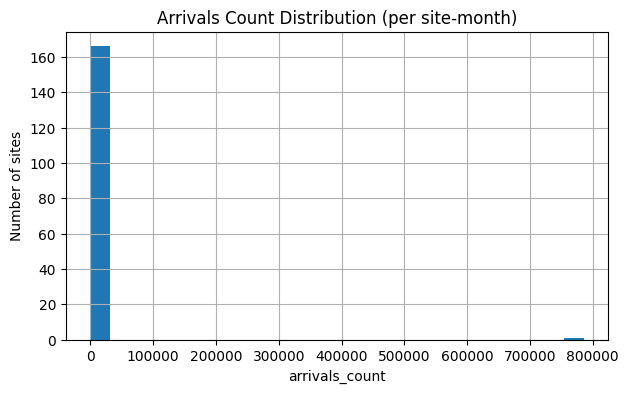

In [8]:
plt.figure(figsize=(7,4))
df['arrivals_count'].hist(bins=25)
plt.title("Arrivals Count Distribution (per site-month)")
plt.xlabel("arrivals_count")
plt.ylabel("Number of sites")
plt.show()

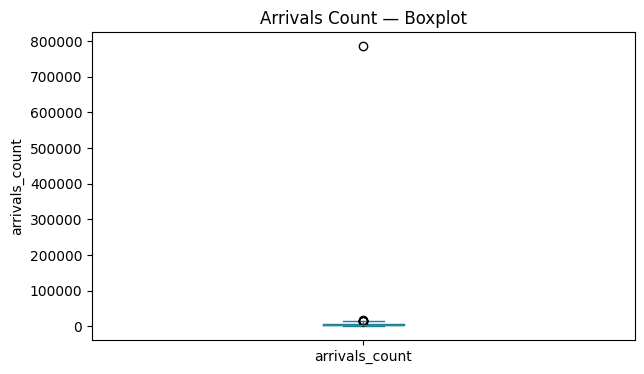

In [9]:
plt.figure(figsize=(7,4))
df['arrivals_count'].plot(kind='box')
plt.title("Arrivals Count — Boxplot")
plt.ylabel("arrivals_count")
plt.show()

### Detailed Interpretation — Arrivals
**Inference:** Sites differ in monthly arrivals; outliers represent unusually high-volume clinics.  
**Key Insights:** High-volume sites are more likely to experience congestion if staffing/capacity is not scaled proportionally.  
**Analytical Meaning:** For queue models, **arrival rate λ** is proportional to arrivals per unit time. With monthly data, we approximate λ using (arrivals / operating minutes).  
**QueueIQ Implications:** QueueIQ can forecast arrivals and flag **surge risk** sites that consistently exceed a demand threshold.


## 6. Concentration / Pareto Analysis (Which sites drive most arrivals?)

In [10]:
# Pareto of arrivals across sites
site_col = 'site_id' if 'site_id' in df.columns else df.columns[0]
arr_by_site = df.groupby(site_col)['arrivals_count'].sum().sort_values(ascending=False)
pareto = arr_by_site.cumsum() / arr_by_site.sum()
pareto.head(10), pareto.tail(1)

(site_id
 TOTAL     0.500000
 R1H       0.511625
 RJ2       0.521709
 R1K       0.531605
 RAL       0.541285
 RF4       0.550665
 RW4       0.559218
 RDE       0.567497
 RTF       0.575543
 RVV       0.583397
 Name: arrivals_count, dtype: float64,
 site_id
 L83087    1.0
 Name: arrivals_count, dtype: float64)

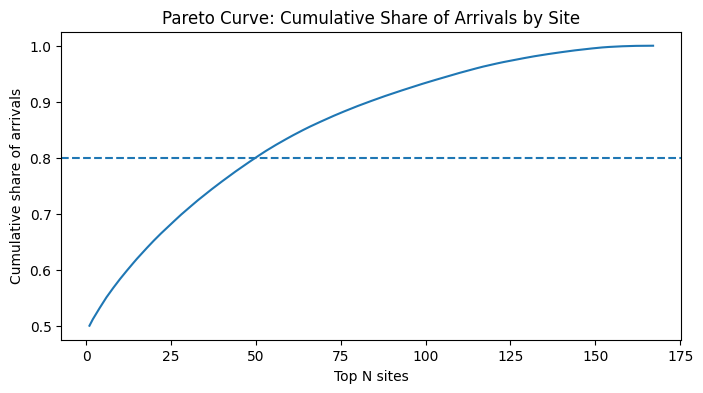

In [11]:
plt.figure(figsize=(8,4))
plt.plot(range(1, len(pareto)+1), pareto.values)
plt.axhline(0.8, linestyle='--')
plt.title("Pareto Curve: Cumulative Share of Arrivals by Site")
plt.xlabel("Top N sites")
plt.ylabel("Cumulative share of arrivals")
plt.show()

### Detailed Interpretation — Pareto
**Inference:** A subset of sites may account for a disproportionate share of total demand.  
**Key Insights:** Targeting improvements at top-demand sites yields the largest overall impact.  
**Analytical Meaning:** For model development, ensure training data includes high-volume sites (they drive congestion).  
**QueueIQ Implications:** QueueIQ rollout strategy: start with top-demand sites for maximum wait-time reduction impact.


## 7. Congestion / SLA Proxy Analysis (Over 4 hours)

In [12]:
df[['over_4h_count','pct_over_4h']].describe()

,over_4h_count,pct_over_4h
count,167.000000,167.000000
mean,302.622754,0.025718
std,1959.583803,0.033974
min,0.000000,0.000000
25%,2.000000,0.001015
50%,46.000000,0.012721
75%,192.000000,0.033698
max,25269.000000,0.179232


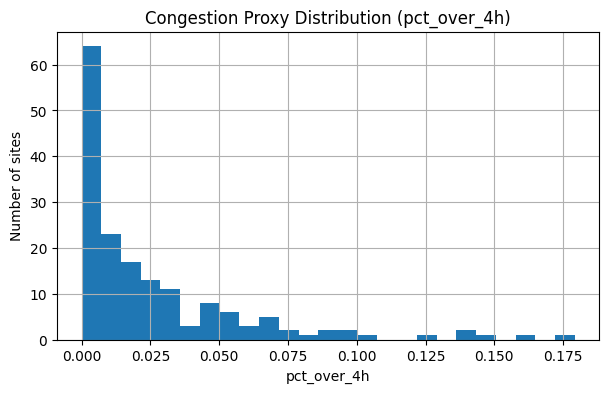

In [13]:
plt.figure(figsize=(7,4))
df['pct_over_4h'].hist(bins=25)
plt.title("Congestion Proxy Distribution (pct_over_4h)")
plt.xlabel("pct_over_4h")
plt.ylabel("Number of sites")
plt.show()

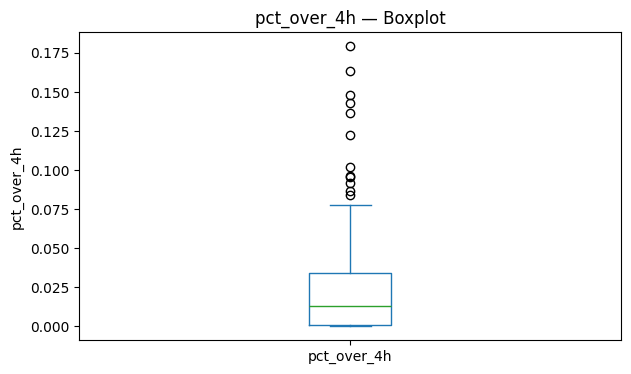

In [14]:
plt.figure(figsize=(7,4))
df['pct_over_4h'].plot(kind='box')
plt.title("pct_over_4h — Boxplot")
plt.ylabel("pct_over_4h")
plt.show()

### Detailed Interpretation — Congestion Proxy
**Inference:** Some sites have high `% over 4h` → persistent congestion.  
**Key Insights:** This KPI can act as an **SLA breach proxy** and a congestion early-warning signal.  
**Analytical Meaning:** Even without direct wait-time, `pct_over_4h` helps model **risk of extreme delays** as a classification/regression target.  
**QueueIQ Implications:** QueueIQ can predict congestion probability and recommend staffing/routing changes before thresholds are breached.


## 8. Booking Mix Analysis (pct_booked)

In [15]:
df['pct_booked'].describe()

count    167.000000
mean       0.273009
std        1.300491
min        0.000000
25%        0.000000
50%        0.000000
75%        0.049518
max       11.631336
Name: pct_booked, dtype: float64

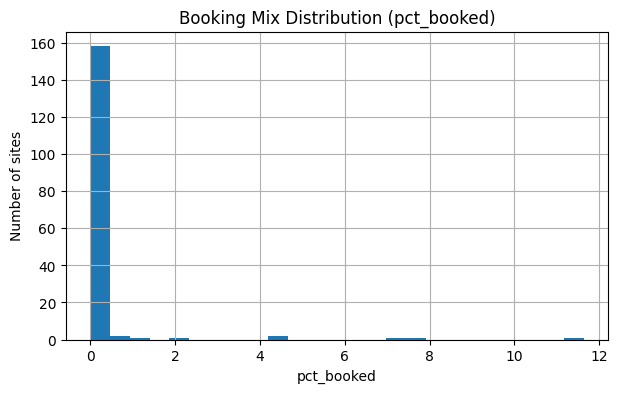

In [16]:
plt.figure(figsize=(7,4))
df['pct_booked'].hist(bins=25)
plt.title("Booking Mix Distribution (pct_booked)")
plt.xlabel("pct_booked")
plt.ylabel("Number of sites")
plt.show()

### Detailed Interpretation — Booking Mix
**Inference:** Some sites are mostly booked while others are more walk-in dominated.  
**Key Insights:** Higher booking tends to reduce randomness; walk-in heavy sites face more unpredictable surges.  
**Analytical Meaning:** Include `pct_booked` as a feature when predicting congestion; it may moderate the arrivals→congestion relationship.  
**QueueIQ Implications:** QueueIQ can recommend different operational strategies based on mix (e.g., appointment smoothing vs walk-in triage routing).


## 9. Relationship Analysis (Arrivals vs Congestion vs Booking Mix)

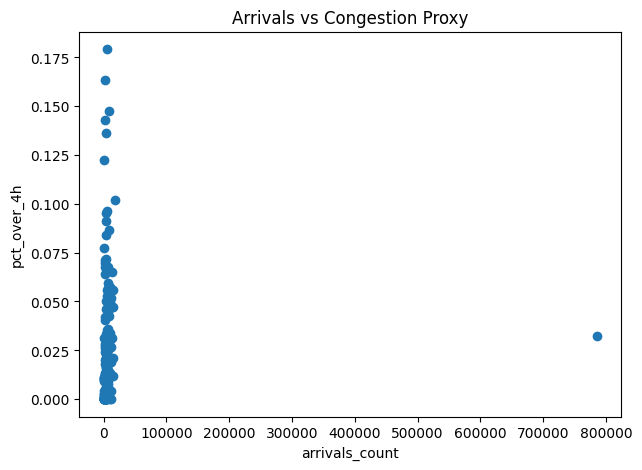

In [17]:
plt.figure(figsize=(7,5))
plt.scatter(df['arrivals_count'], df['pct_over_4h'])
plt.title("Arrivals vs Congestion Proxy")
plt.xlabel("arrivals_count")
plt.ylabel("pct_over_4h")
plt.show()

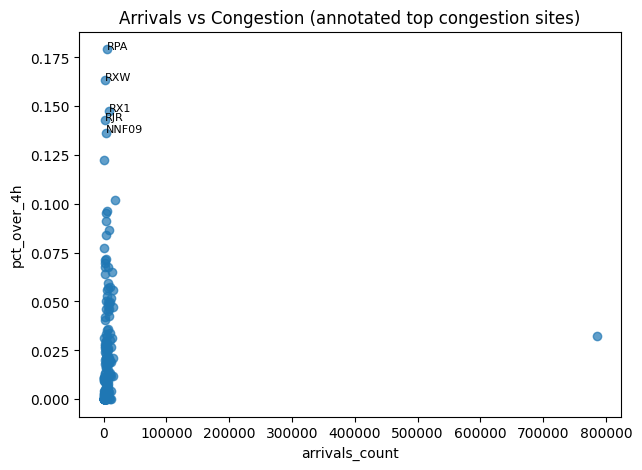

In [18]:
plt.figure(figsize=(7,5))
plt.scatter(df['arrivals_count'], df['pct_over_4h'], alpha=0.7)
# annotate a few top congestion points
top = df.nlargest(min(5, len(df)), 'pct_over_4h')
for _, r in top.iterrows():
    plt.text(r['arrivals_count'], r['pct_over_4h'], str(r.get(site_col, ""))[:8], fontsize=8)
plt.title("Arrivals vs Congestion (annotated top congestion sites)")
plt.xlabel("arrivals_count")
plt.ylabel("pct_over_4h")
plt.show()

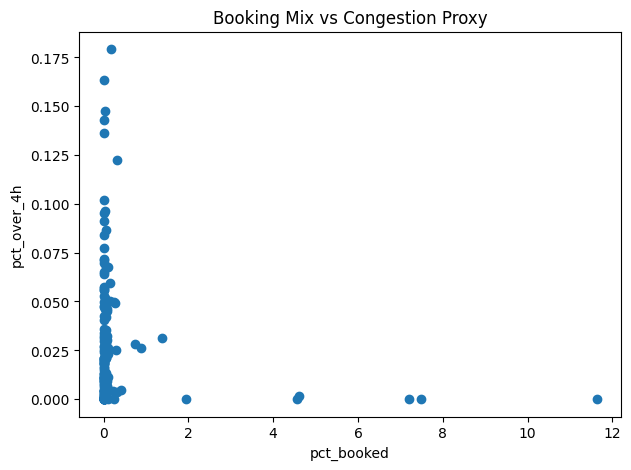

In [19]:
plt.figure(figsize=(7,5))
plt.scatter(df['pct_booked'], df['pct_over_4h'])
plt.title("Booking Mix vs Congestion Proxy")
plt.xlabel("pct_booked")
plt.ylabel("pct_over_4h")
plt.show()

### Detailed Interpretation — Relationships
**Inference:** If congestion rises with arrivals, demand is the dominant driver. If not, operational factors (staffing, layout, processes) may dominate.  
**Key Insights:** Booking mix can act as a stabilizer; high booking might reduce congestion variability even at similar arrivals.  
**Analytical Meaning:** These relationships guide feature selection and model design (e.g., nonlinear regressors).  
**QueueIQ Implications:** QueueIQ should recommend not only “add staff” but also “shift to appointments / stagger intake” when booking mix is low.


## 10. Regional Comparison (if region exists)

In [20]:
region_stats = df.groupby('region').agg(
    sites=('arrivals_count','count'),
    arrivals_mean=('arrivals_count','mean'),
    arrivals_median=('arrivals_count','median'),
    congestion_mean=('pct_over_4h','mean'),
    booked_mean=('pct_booked','mean')
).sort_values('arrivals_mean', ascending=False)
region_stats

,sites,arrivals_mean,arrivals_median,congestion_mean,booked_mean
region,,,,,
TOTAL,1,785405.000000,785405.0,0.032173,0.070240
NHS ENGLAND LONDON,20,7873.050000,6691.0,0.030570,0.018081
NHS ENGLAND EAST OF ENGLAND,16,5083.187500,4676.5,0.014582,0.042118
NHS ENGLAND NORTH WEST,22,4920.772727,3243.5,0.038800,0.112675
NHS ENGLAND NORTH EAST AND YORKSHIRE,25,4767.680000,4059.0,0.027716,0.127137
NHS ENGLAND SOUTH WEST,16,4095.812500,3419.5,0.012952,0.010233
NHS ENGLAND MIDLANDS,35,3837.142857,3101.0,0.026729,1.049418
NHS ENGLAND SOUTH EAST,32,3729.093750,2759.5,0.022776,0.060502


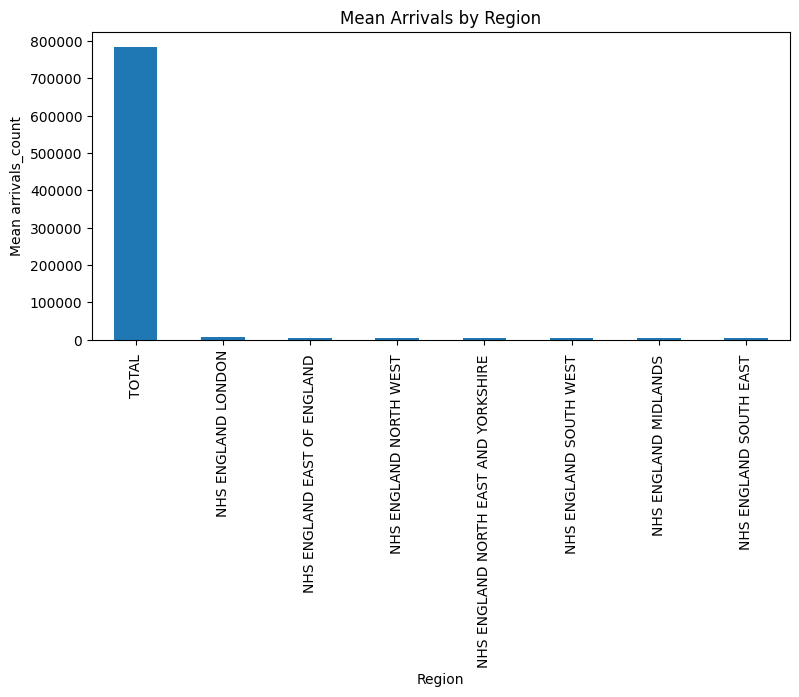

In [21]:
plt.figure(figsize=(9,4))
region_stats['arrivals_mean'].plot(kind='bar')
plt.title("Mean Arrivals by Region")
plt.xlabel("Region")
plt.ylabel("Mean arrivals_count")
plt.show()

### Detailed Interpretation — Region
**Inference:** Regions differ in average demand and congestion.  
**Key Insights:** Regional patterns may reflect population density, clinic capacity, or operational policies.  
**Analytical Meaning:** Region can be used as a grouping variable or hierarchical feature (mixed effects / multi-level modeling).  
**QueueIQ Implications:** Enables regional dashboards and resource planning; supports “where to invest first” decisions.


## 11. Derived Metrics (QueueIQ Feature Engineering)

In [22]:
# Derive simple risk bands for dashboards
df['demand_band'] = pd.qcut(df['arrivals_count'], q=3, labels=['Low','Medium','High'])
df['congestion_band'] = pd.qcut(df['pct_over_4h'], q=3, labels=['Low','Medium','High'])

band_table = pd.crosstab(df['demand_band'], df['congestion_band'], normalize='index')
band_table

congestion_band,Low,Medium,High
demand_band,,,
Low,0.589286,0.232143,0.178571
Medium,0.309091,0.363636,0.327273
High,0.107143,0.392857,0.500000


### Detailed Interpretation — Risk Segmentation
**Inference:** Risk bands segment sites into operational categories (e.g., High demand + High congestion).  
**Key Insights:** Sites in **High demand / High congestion** are primary candidates for staffing interventions.  
**Analytical Meaning:** These engineered features are interpretable and useful for both ML models and decision support.  
**QueueIQ Implications:** QueueIQ can present simple traffic-light indicators and recommend different actions by segment.


## 12. Correlation & Simple Predictive Baselines

In [23]:
corr = df[['arrivals_count','pct_over_4h','pct_booked','over_4h_count']].corr()
corr

,arrivals_count,pct_over_4h,pct_booked,over_4h_count
arrivals_count,1.000000,0.029702,-0.025026,0.994850
pct_over_4h,0.029702,1.000000,-0.121089,0.109702
pct_booked,-0.025026,-0.121089,1.000000,-0.025667
over_4h_count,0.994850,0.109702,-0.025667,1.000000


In [24]:
# Simple baseline: predict congestion from arrivals using a 1D linear fit (illustrative only)
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score

X = df[['arrivals_count','pct_booked']].fillna(0)
y = df['pct_over_4h'].fillna(0)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)
pred = model.predict(X_test)

mae = mean_absolute_error(y_test, pred)
r2 = r2_score(y_test, pred)
(mae, r2, model.coef_, model.intercept_)

(0.028010938393281736,
 -0.023783596132661344,
 array([ 1.72634205e-08, -2.83867724e-03]),
 np.float64(0.024652013608670538))

### Detailed Interpretation — Predictive Baseline
**Inference:** A simple linear model may explain only part of congestion; low R² indicates missing operational drivers (staffing, layout, process, case mix).  
**Key Insights:** Even with aggregated data, arrivals + booking mix can provide a baseline congestion predictor.  
**Analytical Meaning:** For robust prediction, use nonlinear models and incorporate more features (multi-month time series, site capacity proxies).  
**QueueIQ Implications:** QueueIQ should:
- Use forecasting for arrivals, and
- Use ML (e.g., gradient boosting) for congestion risk, plus
- Support simulation-based “what-if” staffing decisions.


## 13. QueueIQ Implications (Forecasting, M/M/c, Staffing, Simulation)

### 13.1 Forecasting (Arrivals)
- With multi-month data, model `arrivals_count` as a time series per site (SARIMA/Prophet) to predict near-term demand.
- In this single-month snapshot, we identify **which sites are high-demand** and thus priority targets.

### 13.2 Queue Modeling (M/M/c or M/G/c)
- This dataset does not include service times; you must assume or import a service-time distribution (e.g., from outpatient service-time datasets).
- Approximate **arrival rate λ** from `arrivals_count` divided by operating time (e.g., clinic hours × days).
- Use M/M/c for a baseline; prefer M/G/c when service times are skewed (common in healthcare).

### 13.3 Staffing Optimization
- High `pct_over_4h` suggests the system is operating at high utilization (ρ near 1) or has insufficient capacity.
- Decision rule: increase `c` (servers) when forecast λ pushes utilization above a target (e.g., ρ > 0.85).

### 13.4 Simulation ("What‑If")
- Use Monte Carlo simulation to estimate distribution of waits and SLA breach risk under alternate staffing levels.
- Scenarios: +1 lane/server, shift coverage, change booking/walk-in mix, routing rules.

### 13.5 Decision-Support Outputs
- Demand band + congestion band → traffic lights.
- Recommended staffing delta (Δc) based on target SLA breach rate.


## 14. Feature Importance & Modeling Recommendations (QueueIQ)

### Feature Importance (from this dataset)
**High-value predictors (available here):**
- `arrivals_count` (primary demand driver; strongest signal for congestion risk)
- `pct_booked` (stabilizes demand; moderates congestion)
- `over_4h_count` (raw breach volume; complements pct)
- `region` (macro grouping; captures structural differences)

**Key missing features (high impact, should be added later):**
- staffing levels (servers on duty per hour/day)
- operating hours / lanes open
- patient mix/acuity (complexity proxy)
- service time distribution (mean, variance, skew)
- within-day arrival distribution (hourly peaks)

### Modeling Recommendations
1) **Congestion risk model (target: `pct_over_4h` or breach probability)**
- Start: Gradient Boosting (XGBoost/LightGBM) with features above.
- Add: multi-month lag features and rolling averages when time series is available.
- Explain: SHAP values for interpretability.

2) **Arrivals forecasting**
- SARIMA/Prophet per site; optionally hierarchical forecasting by region.
- Evaluate: MAE/MAPE and peak error (important operationally).

3) **Queue simulation**
- Use M/G/c simulation with service distribution calibrated from outpatient service-time datasets.
- Evaluate: SLA breach probability, 90th percentile wait proxy, utilization.

4) **Operational recommendations**
- Rule-based guardrails + ML predictions:
  - If forecast arrivals high AND predicted breach risk high → recommend extra server/lane.
  - If booking low → recommend appointment smoothing or triage routing.
